# True Beacon: Quant Research Assignment
- **Submitted By:** Rajesh Saha
- **Email:** rajeshsaha@iisc.ac.in
- **Institute:** Indian Institute of Science (IISc), Bangalore

# Research Thesis
Nifty and Bank Nifty indices have significant overlap in terms of their constituents and weights. Our thesis is that their volatilities are also likely to be affected by similar market conditions and macroeconomic factors. We can thus construct a pairs trading strategy that attempts to capture any dispersion that may occur between the volatilities of the two indices.

This assignment will involve building a pairs trading strategy to test this hypothesis. The output we
are looking for is a medium-frequency strategy that has a trading horizon ranging between 30 min
to 5 days. 

**Medium-Frequency Trading:**
Medium-frequency trading refers to trading that takes place intraday, usually within minutes to hours. Two critical differentiators between MFT and HFT is that MFT doesn’t generally take advantage of market microstructure, and the importance of market impact is significantly smaller. 

The use of special order types, minute differences between exchanges, or order latency doesn’t play much of a role in MFT strategies like they do in HFT. MFTs focus less on market impact because their trades last longer, and they’re taking advantage of more significant price moves, requiring less capital per trade. 

## About Notebook
This research notebook is for understanding Nifty and Bank Nifty indices volatilities as they have significant overlap in terms of their constituents and weights. The objective is exploit the dispersion in their volatilites as they are likely to be affected by similar market conditions and macroeconomic factors. Pairs trading strategies are constructed in the attempts to capture any dispersion that may occur between the volatilities of the two indices. <br><br>
The analysis will be performed on minute level historical data of implied volatilities (IVs) of Bank Nifty and Nifty from Jan 1st 2021 to Jun 30th 2022. 

## Glossary
• **Nifty:** Equity Index representing 50 of the largest and most liquid stocks listed on the National Stock Exchange of India (NSE)

• **Bank Nifty:** Equity Index on the NSE comprising the most liquid and large-capitalized Indian
banking stocks.

• **Option:** a contract that helps you take a view of the direction and volatility of an underlying stock/index.

◦ **Time To Expiry:** refers to the duration from the current date to the expiry date of the option
contract.

• **Index Options:** instruments that allow investors to trade the overall movement of indices like Nifty and Bank Nifty.

• **Pairs Trading:** involves simultaneously buying and shorting two correlated stocks when their prices diverge. The strategy profits from the pair's price ratio returning to its historical norm, aiming to capitalize on relative price movements.

◦ **Volatility Pair Trading:** type of pairs trading strategy that involves taking advantage of the difference in volatility between two correlated securities. The strategy assumes that the volatility will either return to or move away from the historical mean.

• **Implied Volatility (IV):** metric that reflects the market’s expectation of future volatility of the
underlying asset or index price. 


## Dataset
1. Time series of minute-level implied volatilities (IVs) of Bank Nifty and Nifty.
2. Time To Expiry (TTE) for the series.
3. Indian market trading hours are between 09:15 and 15:30.
4. There may be some missing values in the dataset.
5. The formula to calculate P/L has been specified below. If you modify your IV or spread series, make sure you modify the P/L equation as well.

## Deliverables
1. Build a z-score based trading system. It would use the z-scores of the spread to identify when
volatility has diverged away from the historical mean and act accordingly. The calculation of the
P/L here constitutes the base model.

2. Build a better model than the z-score trading system. Be creative in the modelling techniques
you implement.
3. Compare your proposed model with the base model with the goal of optimizing the absolute
P/L, Sharpe Ratio, and Drawdown of your strategy.

### Formulae:
**Spread = Bank Nifty IV − Nifty IV**

**P/L = Spread × (Time To Expiry)^0.7**

In [1]:
import numpy as np # For numerical computation
import pandas as pd # For data manipulation

from matplotlib import style # For asthetics
import matplotlib.pyplot as plt # For vizualiation
plt.style.use('seaborn-v0_8-ticks')

from itertools import product # This function computes the Cartesian product of input iterables. 
#It's commonly used when you need to iterate over all possible combinations of elements from multiple iterables.

from tqdm.notebook import tqdm # It provides a visual progress bar for tasks running in a notebook environment.

# Step 1: Data Preprocessing
The data is provide as a parquet file and I have used pandas with default parquet engine. 

In [2]:
df = pd.read_parquet('data.parquet')
df.head()

,banknifty,nifty,tte
time,,,
2021-01-01 09:15:00,0.286058,0.199729,27
2021-01-01 09:16:00,0.285381,0.200433,27
2021-01-01 09:17:00,0.284233,0.200004,27
2021-01-01 09:18:00,0.286104,0.199860,27
2021-01-01 09:19:00,0.285539,0.198951,27


In [3]:
df.isna().sum()# check for missing values

banknifty    1500
nifty        2000
tte             0
dtype: int64

In [4]:
# Handle missing values
df = df.dropna()
df.shape

(687013, 3)

In [5]:
df.isnull().sum()

banknifty    0
nifty        0
tte          0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 687013 entries, 2021-01-01 09:15:00 to 2022-06-30 15:30:00
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   banknifty  687013 non-null  float64
 1   nifty      687013 non-null  float64
 2   tte        687013 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 18.3 MB


In [7]:
df.describe()

,banknifty,nifty,tte
count,687013.000000,687013.000000,687013.000000
mean,0.250154,0.179344,15.672436
std,0.057699,0.046139,8.664269
min,0.152732,0.089355,2.000000
25%,0.205307,0.140375,8.000000
50%,0.243977,0.181210,15.000000
75%,0.295293,0.215631,23.000000
max,0.460619,0.306952,31.000000


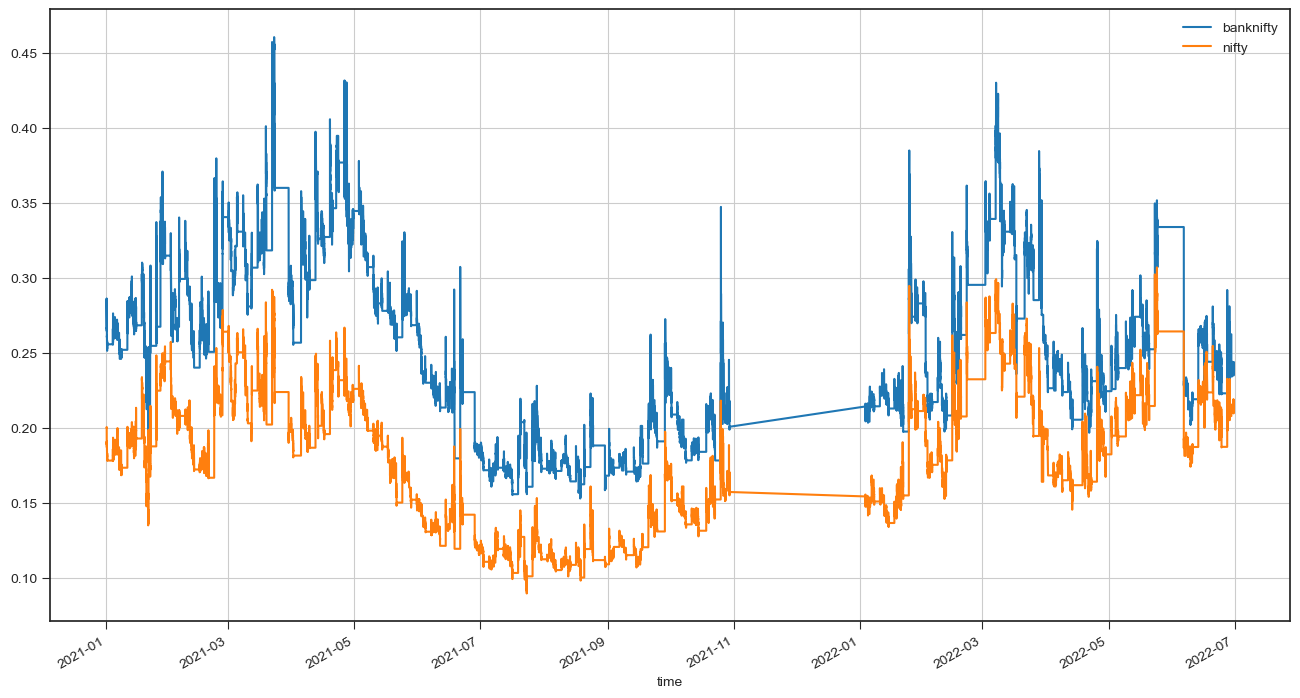

In [8]:
df = df.fillna(method='ffill') # impute the missing values
# plot banknifty and nifty IVs
df[['banknifty', 'nifty']].plot(figsize=(16,9), grid=True);

# Step 2: Feature Engineering
In this step, we calculate the spread between Bank Nifty IV and Nifty IV. Then we adjust this spread for Time To Expiry according to the specified formula to calculate P/L.

### Computing the spread
It is simply the difference between the two IVs, given as - <br><br>
$$
\text{Spread} = \text{Bank Nifty IV} - \text{Nifty IV}$$

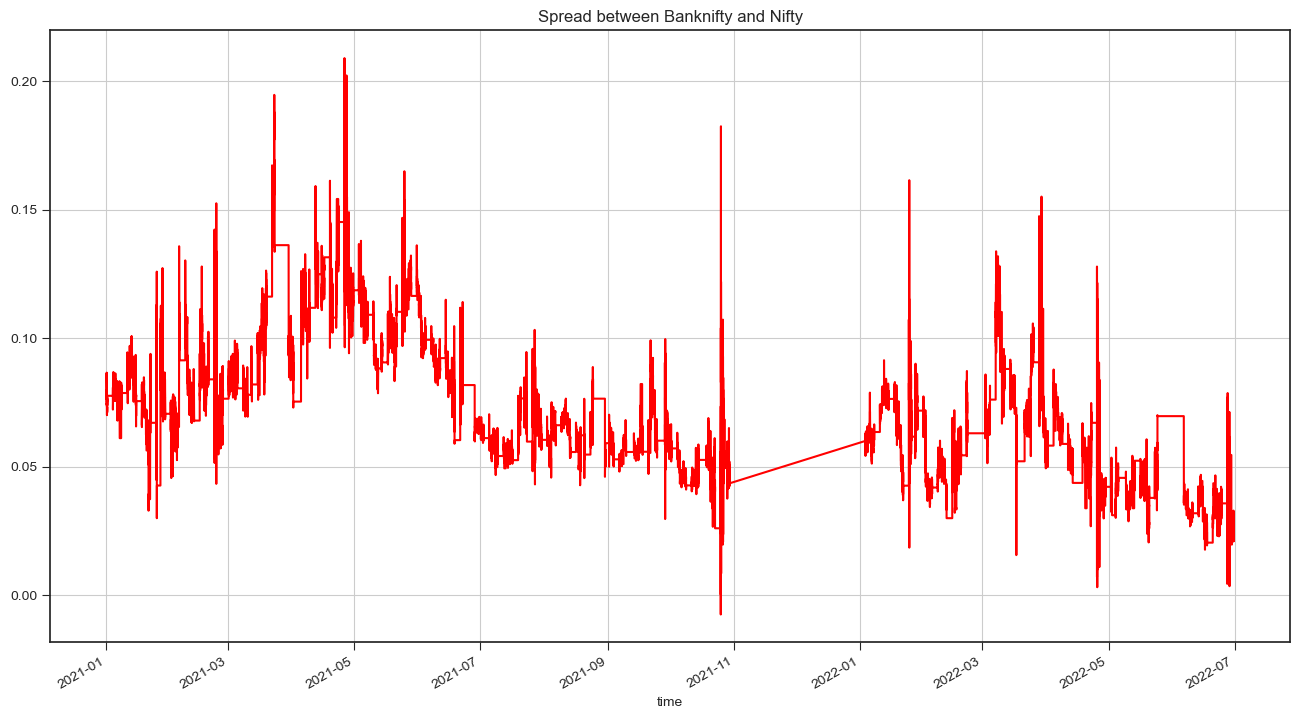

In [9]:
# Calculate spread
spread = df['banknifty'] - df['nifty']
spread.name = 'spread'
df['spread'] =spread
spread.plot(figsize=(16,9), color='red', grid=True, title='Spread between Banknifty and Nifty');

### Adjusting the spread for time decay
Since implied volitility decays with time to expiry we need to adjust the spread between IVs with time to expiry (TTE) as follows - <br><br>
$$
\text{P/L} = \text{Spread} \times (\text{Time To Expiry})^{0.7}$$

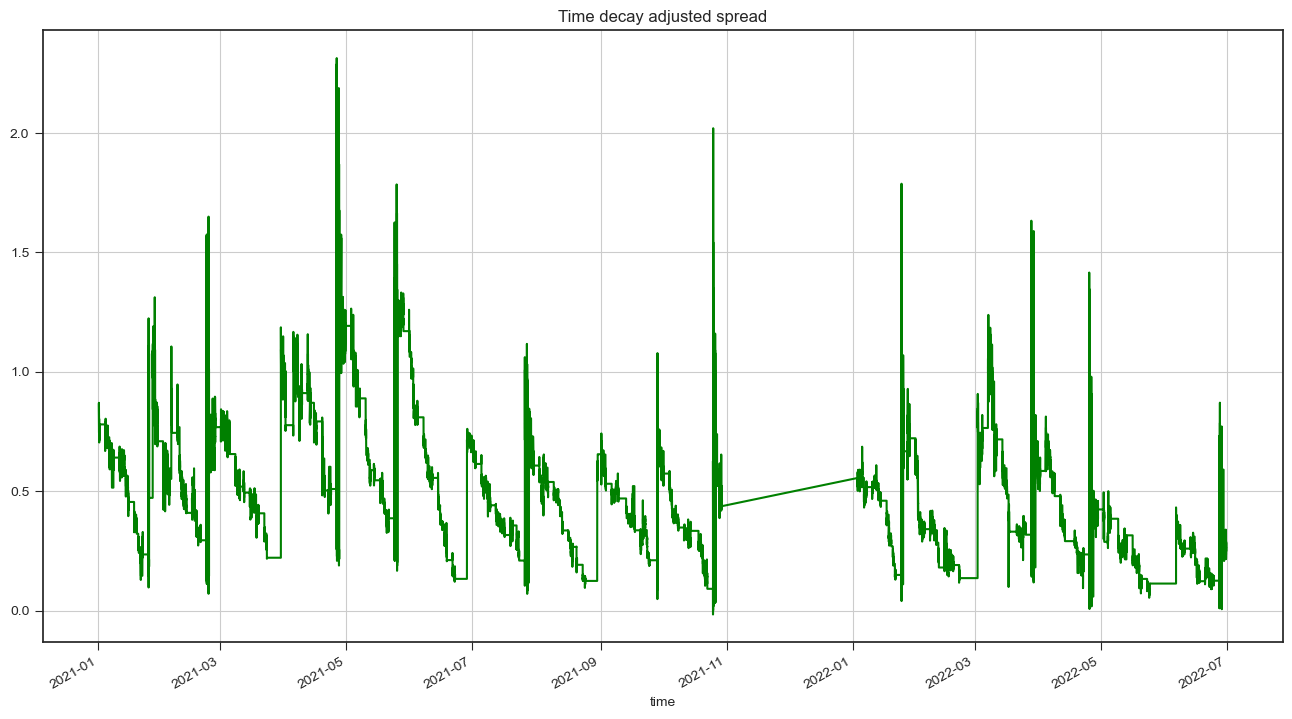

In [10]:
# Calculate P/L
PL = spread*(df['tte']**0.7)
PL.name = 'PL'
df['P/L']=PL
PL.plot(figsize=(16,9), color='green', grid=True, title='Time decay adjusted spread');

### Spliting data for in-sample and out-of-sample analysis

In [11]:
offset = pd.Timedelta('255D') # 1 year of insample data
start = df.index[0] # starting date of the dataset
ins, oos = df[:start+offset], df[start+offset:] #insample and out of sample split respectively

### Sharpe Ratio:

The Sharpe Ratio is a measure of risk-adjusted return, calculated by dividing the excess return of an investment (i.e., the return above the risk-free rate) by its standard deviation of returns. It provides insight into how well the return of an investment compensates for the risk taken.

**Formula:** Sharpe Ratio = (Mean Return - Risk-Free Rate) / Standard Deviation of Returns

Higher values of the Sharpe Ratio indicate better risk-adjusted performance. A Sharpe Ratio greater than 1 is generally considered acceptable, while values above 2 are considered good and values above 3 are considered excellent.

**Significance:** A higher Sharpe Ratio suggests that the investment strategy generates higher returns per unit of risk taken, making it more attractive to investors.

### Drawdown:

Drawdown measures the peak-to-trough decline in the value of an investment during a specific period. It represents the maximum loss an investor would have incurred if they bought at the peak and sold at the trough.

Drawdown is expressed either in absolute terms (e.g., currency units or percentage) or relative to the previous peak value.

**Significance:** Drawdown is an essential metric for assessing the risk and resilience of an investment strategy. A larger drawdown implies higher risk and greater potential losses. Understanding drawdowns helps investors manage risk and set appropriate expectations regarding potential downside volatility.

### Vectorized Backtester Parent Class

In [12]:
class VectorizedBT(object):
    """
    A class to backtest trading signals 
    using vectorized backtesting method.
    """
    def __init__(self):
        pass
        
    def get_signals(self):
        """
        Implement the strategy signals here.

        :return : None
        """
        raise NotImplementedError('Subclass must implement this!')
        
    def run(self)->None:
        """
        Run the vectorized backtest.
        """
        self.signals = self.get_signals()
        returns = (1+self.PL).pct_change()[1:]
        pnl = self.PL.diff()[1:]
        self.returns_strat = self.signals * returns
        self.pnl_strat = self.signals * pnl
  
    def get_summary(self, show=True)->None:
        """
        Calculate the backtest summary results.

        :param show: (bool) whether to print the report 
        :return : None
        """
        #Calculate cumulative P&L
        self.equity_pnl = self.pnl_strat.cumsum()
        #Calculate the sharpe ratio
        self.sharpe = np.nanmean(self.returns_strat)/np.nanstd(self.returns_strat)*np.sqrt(252*375)
        #Calculate running maximum
        running_max = self.equity_pnl.cummax()
        #Calculate drawdown
        drawdowns = self.equity_pnl - running_max
        #Maximum Drawdown
        max_dd = drawdowns.min()
        entries = self.signals.diff()[1:]
        if show:
            #Print Metrics
            print("                   Results              ")
            print("-------------------------------------------")
            print("%14s %21s" % ('statistic', 'value'))
            print("-------------------------------------------")
            print("%20s %20.2f" % ("Absolute P&L :", self.equity_pnl[-1]))
            print("%20s %20.2f" % ("Sharpe Ratio :", self.sharpe))
            print("%20s %20.2f" % ("Max. Drawdown P&L:", round(max_dd, 2)))
            #print("%20s %20.2f" % ("Total Trades :", sum(abs(entries))))
            #Plots
            x = self.equity_pnl.index
            #fig, axs = plt.subplots(4, figsize=(16, 15), height_ratios=[4, 3, 4, 4])
            fig, axs = plt.subplots(3, figsize=(16, 12), height_ratios=[4, 4, 4])
            fig.suptitle('Backtest Report', fontweight="bold")
            axs[0].plot(x, self.spread.values, color='#aec6cf')
            axs[0].title.set_text("P/L")
            axs[0].grid()
            # axs[1].plot(x, self.signals.values, color='#aec6cf')
            # axs[1].title.set_text("Positions")
            # axs[1].grid()
            axs[1].plot(x, self.equity_pnl.values, color='#77dd77')
            axs[1].title.set_text("Strategy Equity Curve : P&L")
            axs[1].grid()
            axs[2].fill_between(x, drawdowns.values, color='#ff6961', alpha=0.5)
            axs[2].title.set_text("Drawdowns : P&L")
            axs[2].grid()
            plt.show()

#### The above provided code defines a parent class named VectorizedBT for backtesting trading signals using vectorized methods. Here's a summary of the key components and functionality of this code:

#### Class Definition: 
The VectorizedBT class is defined, which serves as a blueprint for backtesting trading strategies.

#### Constructor Method (__init__): 
The class has an __init__ method, which serves as the constructor. However, it doesn't perform any initialization in this implementation.

#### get_signals Method: 
This method is intended to be implemented by subclasses. It's responsible for generating trading signals based on the specific strategy being tested. If not implemented by a subclass, it raises a NotImplementedError.

#### run Method: 
This method executes the backtest. It first obtains the trading signals by calling the get_signals method, calculates returns and pnl based on these signals, and stores them in the returns_strat and pnl_strat attributes.

#### get_summary Method: 
This method calculates summary statistics of the backtest results, such as cumulative P/L, Sharpe ratio, maximum drawdown, etc. It also has an optional show parameter, which when set to True, prints the calculated metrics and plots the P/L curve and drawdowns.

#### Summary Metrics: 
The summary metrics printed include:
Absolute P&L, Sharpe Ratio, Maximum Drawdown.

#### Plots: 
Three plots are generated and displayed if show is set to True. These plots include: P/L (Profit/Loss), Strategy Equity Curve, Drawdowns

### Optimizer for optimizing a trading strategy

In [13]:
class Optimizer:
    def __init__(self, strategy:VectorizedBT, df:pd.DataFrame):
        self.strategy = strategy
        self.df = df
        
    def search(self, params:dict={}, category:str='sharpe')->None:
        """
        Run grid search over the parameters.
        Returns the optimal parameters for 
        the strategy that maximize the 
        category.
        
        :param category :(str) Use either 'sharpe' or 'pnl'
        :param params :(dict) search dictionary for the 
                        strategy parameters. Make sure 
                        the keys are the arguments of strategy.
        :return : None
        """
        keys = list(params.keys())
        search_space = [dict(zip(keys, values)) for values in product(*params.values())]
        self.best_category_val = -np.inf
        self.best_param = None
        for search_param in tqdm(search_space):
            this_strat = self.strategy(self.df, **search_param)
            this_strat.run()
            this_strat.get_summary(False)
            val = None
            if category=='sharpe':
                val = this_strat.sharpe
            elif category=='pnl':
                val = this_strat.equity_pnl
            else:
                raise ValueError("Invalid Category.")
                
            if val > self.best_category_val:
                self.best_category_val = val
                self.best_param = search_param
        print(f"Best {category} score achived : {self.best_category_val}\n")
        print(f"Best parameters for the above score : {self.best_param}") 

#### The Optimizer class provided above is designed to optimize a trading strategy by performing a grid search over specified parameters and selecting the best combination of parameters that maximize a given metric, either 'sharpe' or 'pnl'. Here's a summary of the key components and functionality of this class:

#### Class Definition: 
The Optimizer class is defined to optimize trading strategies.

#### params: 
A dictionary containing the search space for strategy parameters. The keys are the arguments of the strategy.

#### category: 
A string specifying the metric to maximize, either 'sharpe' or 'p/l'.

#### Grid Search: 
The method constructs a search space by generating all possible combinations of parameters specified in the params dictionary using itertools.product(). It then iterates over each combination, initializing a new instance of the strategy with the current parameter combination, running the backtest, and calculating the specified metric ('sharpe' or 'pnl').

#### Best Parameter Selection: 
It keeps track of the best parameter combination that maximizes the specified metric. Once the grid search is complete, it prints the best achieved score and the corresponding best parameters.

# Step 3: Base Model - Z-score based trading system
A z-score-based pairs trading strategy involves identifying pairs of assets with historically co-moving prices and calculating the z-score of the spread between their prices. The z-score quantifies how far the current spread is from its historical average in terms of standard deviations. Traders typically enter a long position when the z-score is below a threshold $\gamma$ (indicating the spread is below its average) and a short position when it's above the threshold $\gamma$. The strategy aims to capitalize on mean-reverting behavior, as extreme spreads are expected to revert to their historical averages over time. <br><br>
z-score is calculated as - 
$$z = \frac{x-\mu}{\sigma}$$
where, <br>$x = \text{Spread}$<br>
$\mu = \text{Mean Spread}$<br>
$\sigma = \text{Standard Deviation of Spread}$<br>

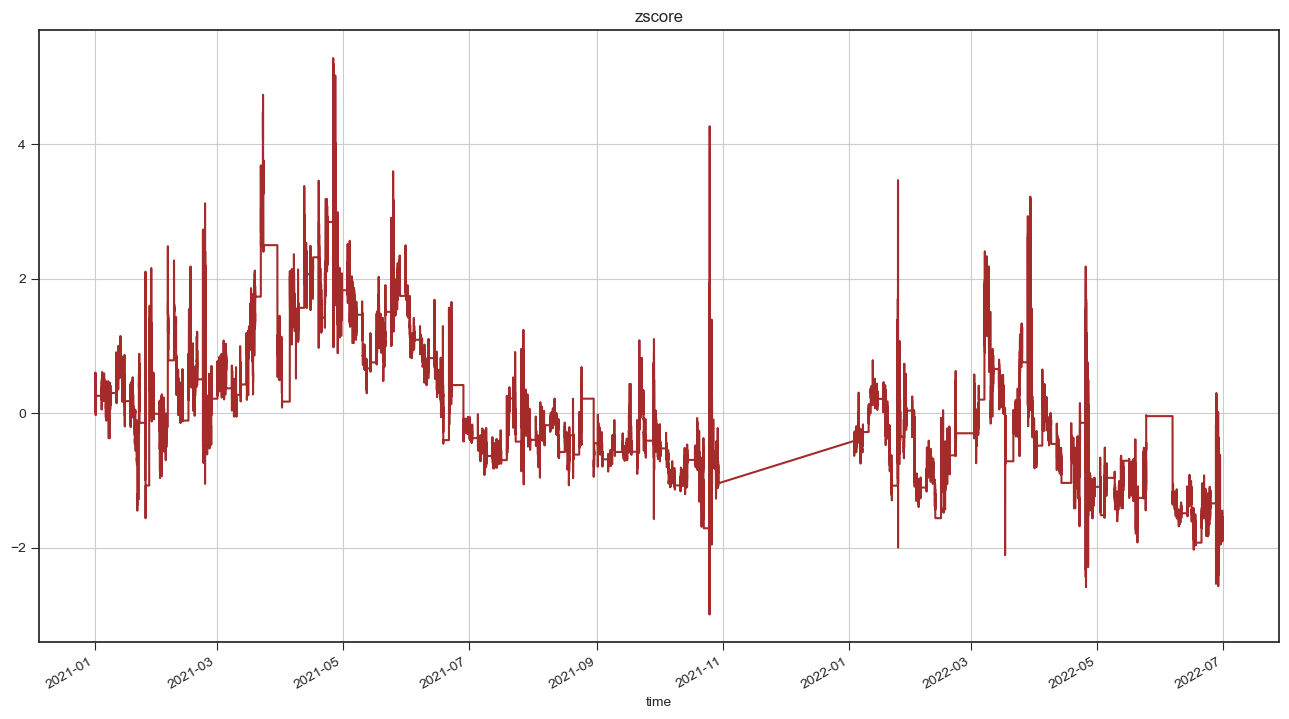

In [14]:
zscore = (spread - spread.mean()) / np.std(spread)
df['zscore']=zscore
zscore.plot(figsize=(16,9), color='brown', grid=True, title='zscore');

**Time series plot of Spread and Z-score:** Plotting the spread and its corresponding z-score over time allows us to visually identify periods of divergence or convergence in volatility between Bank Nifty and Nifty. This helps in understanding the behavior of the spread and its relationship with the z-score.

In [15]:
df

,banknifty,nifty,tte,spread,P/L,zscore
time,,,,,,
2021-01-01 09:15:00,0.286058,0.199729,27,0.086329,0.867184,0.592560
2021-01-01 09:16:00,0.285381,0.200433,27,0.084948,0.853317,0.539849
2021-01-01 09:17:00,0.284233,0.200004,27,0.084229,0.846089,0.512377
2021-01-01 09:18:00,0.286104,0.199860,27,0.086244,0.866325,0.589296
2021-01-01 09:19:00,0.285539,0.198951,27,0.086588,0.869786,0.602449
...,...,...,...,...,...,...
2022-06-30 15:26:00,0.240701,0.214758,28,0.025943,0.267320,-1.713119
2022-06-30 15:27:00,0.240875,0.216558,28,0.024317,0.250560,-1.775222
2022-06-30 15:28:00,0.242115,0.216794,28,0.025321,0.260910,-1.736868


**Time series plot of Spread and Z-score:** Plotting the spread and its corresponding z-score over time allows us to visually identify periods of divergence or convergence in volatility between Bank Nifty and Nifty. This helps in understanding the behavior of the spread and its relationship with the z-score.

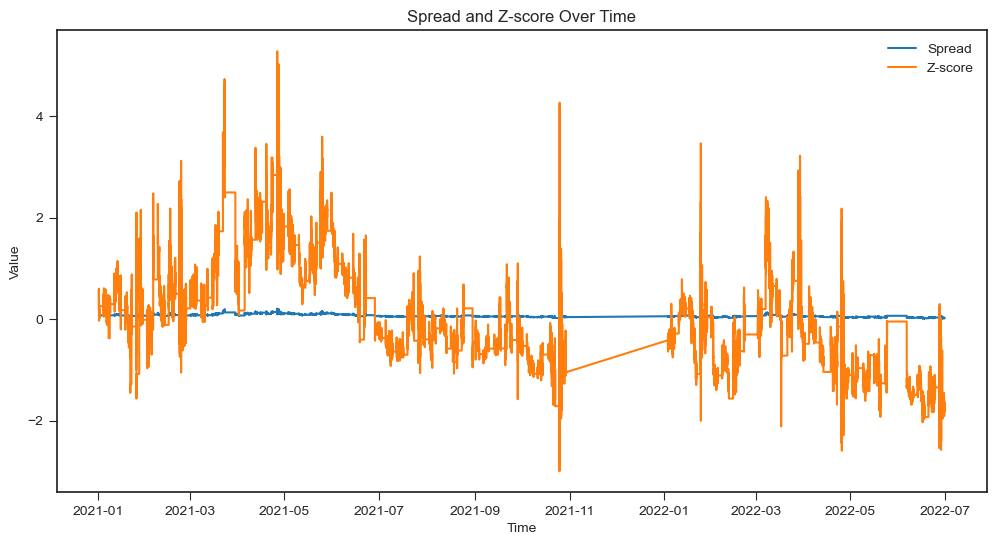

In [16]:
# Time series plot of Spread and Z-score
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['spread'], label='Spread')
plt.plot(df.index, df['zscore'], label='Z-score')
plt.title('Spread and Z-score Over Time')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

**Histogram of Z-score:** Histogram of the z-score distribution provides insights into the distribution of the spread's deviations from its mean. This visualization helps in understanding the frequency and magnitude of extreme events (e.g., high volatility divergence) which can trigger trading signals.

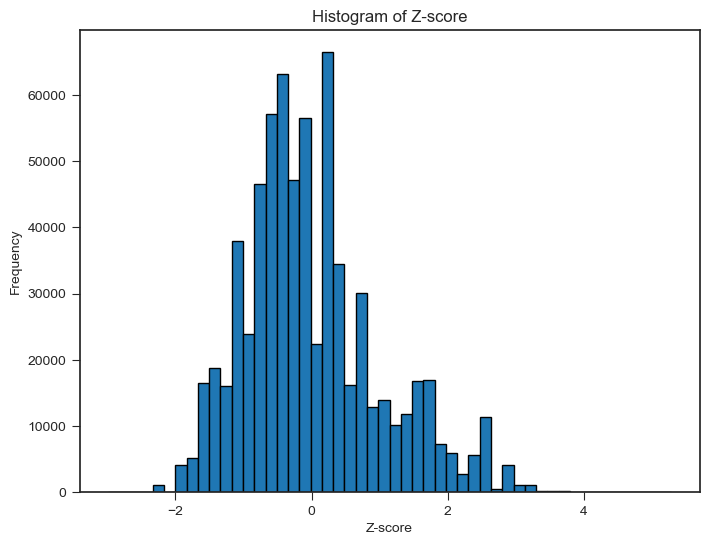

In [17]:
# Histogram of Z-score
plt.figure(figsize=(8, 6))
plt.hist(df['zscore'], bins=50, edgecolor='black')
plt.title('Histogram of Z-score')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.show()

### Strategy Implementation
- Compute a moving average ($\mu_n$) of length $n$ (`window size`) on the spread.
- Compute a moving standard deviation($\sigma_n$) of length $n$ (`window size`) on the spread.
- Get the rolling zscore as $z = \frac{\text{Spread}-\mu_n}{\sigma_n}$

#### Trading Rules : 
- Go Long : $z < -\gamma$<br>
- Go Short : $z > \gamma$<br>
- Exit Long : $z > 0$<br>
- Exit Short : $z < 0$<br>

In [18]:
class ZScoreStrategy(VectorizedBT):
    """
    Z-Score based strategy implementation 
    as vectorized backtesting.
    """
    def __init__(self, df, window_size=30, 
                 entry_level=2, exit_level=0):
        # initialized the VecotrizedBT class
        super(ZScoreStrategy, self).__init__()
        # define the spread
        self.spread = df['banknifty'] - df['nifty']
        # get the decay adjusted spread
        self.PL = self.spread*(df['tte']**0.7)
        # define window size
        self.window = window_size
        # compute the moving average
        mavg = self.spread.rolling(self.window).mean()
        # compute the moving standard deviation
        std = self.spread.rolling(self.window).mean().std()
        # get the rolling score
        self.rolling_zscore = ((self.spread - mavg)/std).dropna()
        # define the thresholds
        self.entry_level = entry_level
        self.exit_level = exit_level
        
    def get_signals(self)->pd.Series:
        """
        Returns the signals from z-score strategy.
        """
        # convert to numpy array for faster computation
        zscore = np.asarray(self.rolling_zscore)
        # get indices for long and short positions
        longs_entry = zscore < -self.entry_level
        longs_exit = zscore > -self.exit_level
        shorts_entry = zscore > self.entry_level
        shorts_exit = zscore < self.exit_level
        # pandas series for storing long short signals
        num_units_long = pd.Series([np.nan for i in range(len(zscore))])
        num_units_short = pd.Series([np.nan for i in range(len(zscore))])
        # set threshold crossings with corresponding position
        num_units_long[longs_entry] = 1.
        num_units_long[longs_exit] = 0
        num_units_short[shorts_entry] = -1.
        num_units_short[shorts_exit] = 0
        # shift to simulate entry delay (of 1 min) in real life trading
        num_units_long = num_units_long.shift(1)
        num_units_short = num_units_short.shift(1)
        # initialize market position with zero
        num_units_long[0] = 0.
        num_units_short[0] = 0.
        # finally, fill in between
        num_units_long = num_units_long.fillna(method='ffill')
        num_units_short = num_units_short.fillna(method='ffill')
        num_units = num_units_long + num_units_short
        # signals series
        signals = pd.Series(0, index=self.spread.index, name='signals')
        signals[self.rolling_zscore.index] = num_units
        return signals

#### The above provided code defines a subclass named ZScoreStrategy, which inherits from the VectorizedBT class. This subclass implements a trading strategy based on Z-Scores using vectorized backtesting. Here's a summary of its key components and functionality:

#### Class Definition: 
The ZScoreStrategy class is defined as a subclass of VectorizedBT.

#### window_size: 
Size of the rolling window used for calculating the moving average and standard deviation of the spread.

#### entry_level: 
Z-score threshold for entering a position.

#### exit_level: 
Z-score threshold for exiting a position.

#### Initialization: 
It initializes the parent class VectorizedBT and computes the spread and decay-adjusted spread (PL). It also calculates the rolling Z-score using the provided window size.

#### get_signals Method: 
This method overrides the get_signals method of the parent class. It computes trading signals based on the Z-score strategy:

-It converts the rolling Z-score to a NumPy array for faster computation.

-It identifies entry and exit points for long and short positions based on the specified entry and exit levels.

-It creates Pandas series (num_units_long and num_units_short) to store the position signals for long and short positions.

-It simulates a delay in entry (of 1 minute) by shifting the signals.

-It fills NaN values using forward filling method.

-It combines the signals for long and short positions.

-It creates a Pandas Series (signals) to store the final signals for the strategy.

                   Results              
-------------------------------------------
     statistic                 value
-------------------------------------------
      Absolute P&L :                90.98
      Sharpe Ratio :                 3.77
  Max. Drawdown P&L:                -1.69


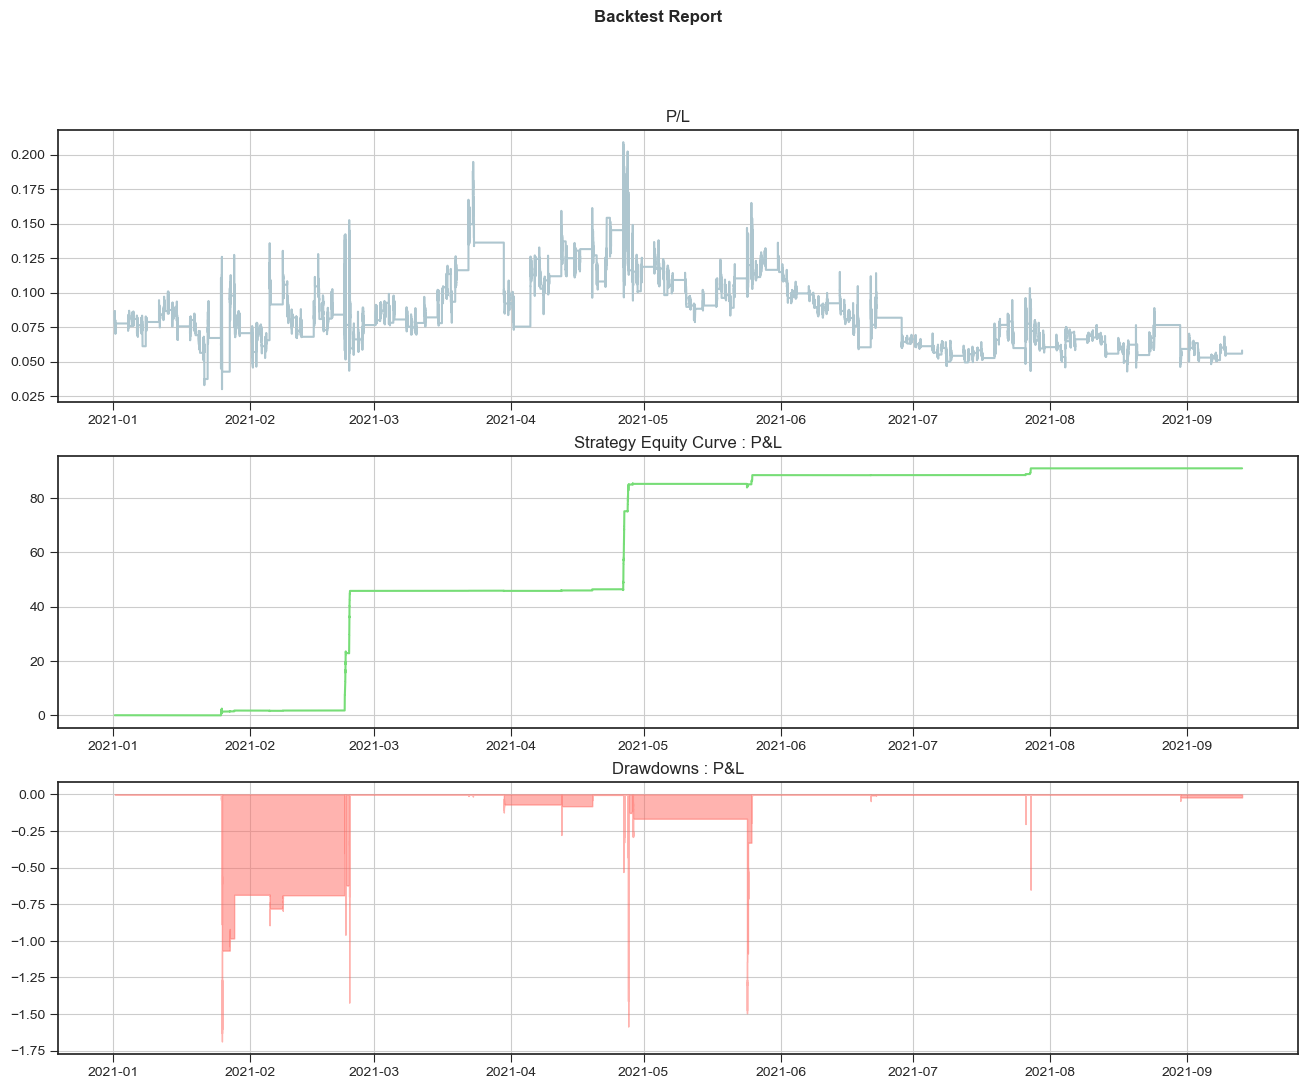

In [19]:
# initialize the backtest
strat = ZScoreStrategy(ins, 30, entry_level=1, exit_level=0)
# run the backtest
strat.run()
# get the backtest summary
strat.get_summary()

## Optimizing Z-Score based Trading System

The Optimizer instance 'opt' is then used to search for the optimal combination of these parameters, maximizing either the Sharpe ratio or the P&L, based on the defined strategy.

### In-sample performance

In [20]:
opt = Optimizer(ZScoreStrategy, ins) # initialize the optimizer with ZScoreStrategy
# search paramters
params = {'entry_level':[1,1.25,1.69,2], 'exit_level':{0,0.5}}
# run search
opt.search(params)

  0%|          | 0/8 [00:00<?, ?it/s]

Best sharpe score achived : 3.966659738634039

Best parameters for the above score : {'entry_level': 1, 'exit_level': 0.5}


### Out of Sample performance

                   Results              
-------------------------------------------
     statistic                 value
-------------------------------------------
      Absolute P&L :               160.39
      Sharpe Ratio :                 6.66
  Max. Drawdown P&L:                -1.94


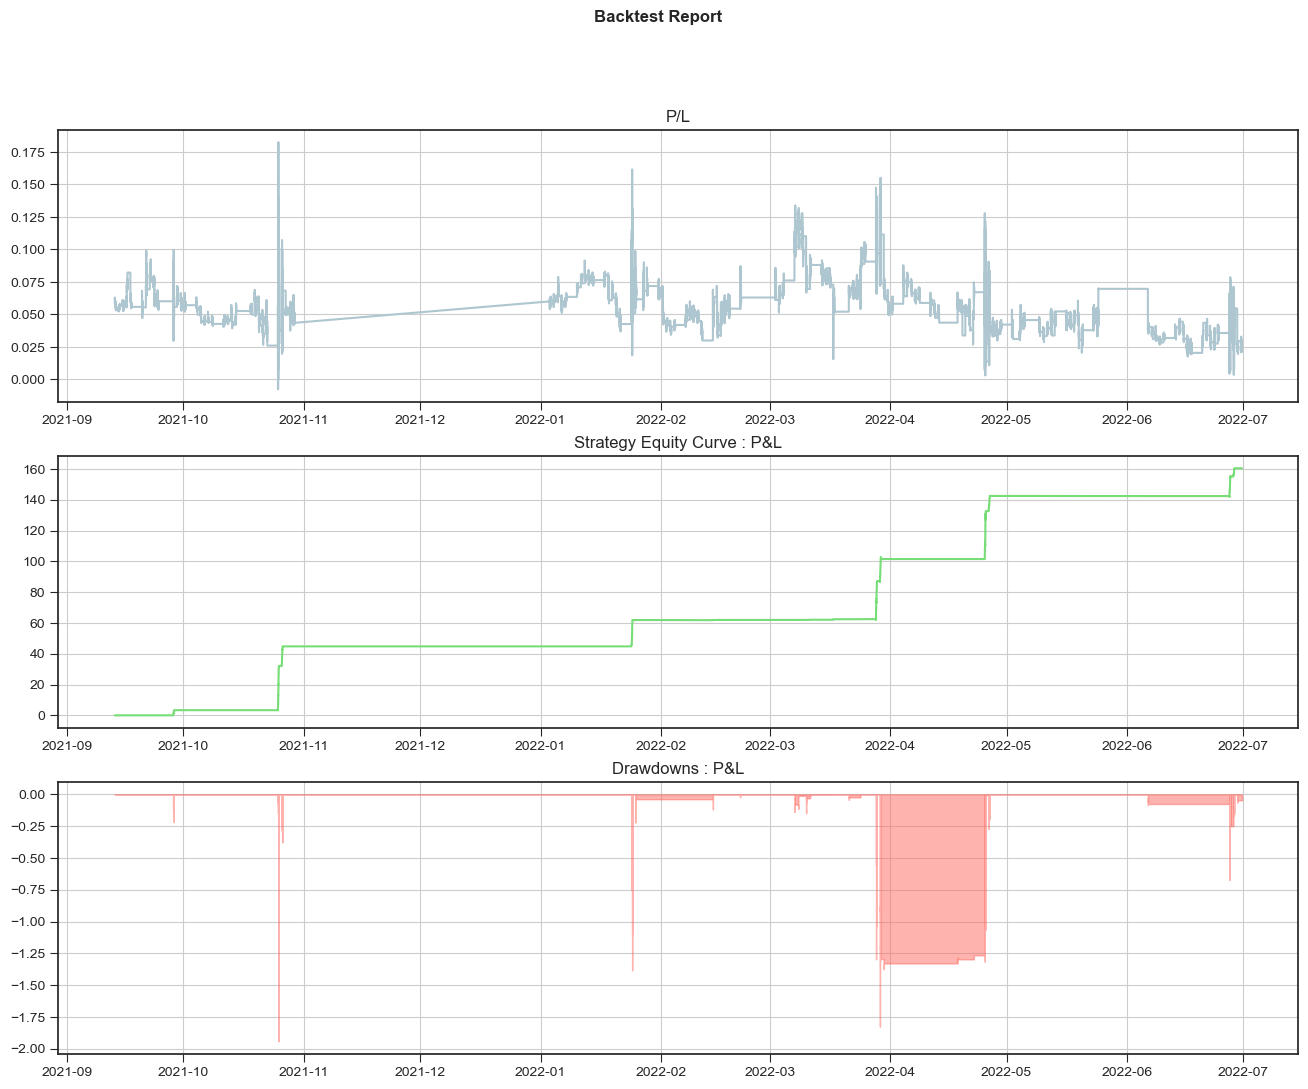

In [21]:
# initialize the backtest
strat = ZScoreStrategy(oos, 30, entry_level=1, exit_level=0.5)
# run the backtest
strat.run()
# get the backtest summary
strat.get_summary()

# Step 4: Improved Model - Quintile based trading system

A quintile is a data value in statistics that represents 20% of a population. It is one of five values that divide a range of data into five equal parts. A quantile is a value at or below which a given fraction of data lies. Quantiles include quintiles, quartiles, and percentiles. 


Let the spread change at $t$ be defined as - $$\Delta x_{t+1} = x_{t+1} - x_t$$
From the distribution $f(\Delta x)$, the set of negative (negative changes) and
positive (positive changes) values are considered separately, originating
the distributions $f^-(\Delta x)$  and $f^+(\Delta x)$,
respectively. <br> <br> The proposed model targets abrupt changes but also requires that they occur
frequently enough, looking for the extreme quantiles seems adequate. As quantiles
adapt to the spread volatility, the thresholds will ultimately be linked to the spread’s
properties.
<br>
<br>
A quintile is any of the four values that divide the sorted data into five equal parts,
so that each part represents 15 of the sample or population. It takes any of the values
$Q_{\Delta x}(0.20)$, $Q_{\Delta x}(0.40)$, . . . , $Q_{\Delta x}(0.80)$.

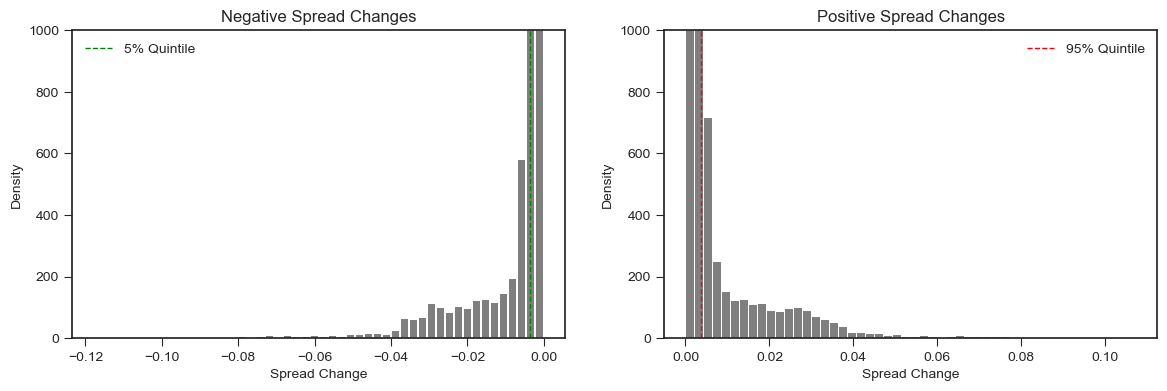

In [22]:
# compute the spread changes
spread_change = spread.diff()[1:]
# postive changes
positive_spread_change = spread_change[spread_change > 0]
# negative changes
negative_spread_change = spread_change[spread_change < 0]
# get the short threshold
short_threshold = positive_spread_change.quantile(q=0.95, interpolation='linear')
# get the long threshold postive changes
long_threshold = negative_spread_change.quantile(q=0.05, interpolation='linear')
# create subplots 
fig, axs = plt.subplots(1,2, figsize=(14, 4))

#plot the positive changes
axs[1].hist(x=np.asarray(positive_spread_change.values), 
            bins=50, align='mid', rwidth=0.8, color='k', alpha=0.5)
axs[1].axvline(x=short_threshold, color='red', linestyle='--', linewidth=1, label='95% Quintile')
axs[1].set_title('Positive Spread Changes')
axs[1].set(xlabel='Spread Change', ylabel='Density')
axs[1].set_ylim((0, 1000))  
axs[1].legend()

#plot the negative changes
axs[0].hist(x=np.asarray(negative_spread_change.values),
            bins=50, align='mid', rwidth=0.8, color='k', alpha=0.5)
axs[0].axvline(x=long_threshold, color='green', linestyle='--', linewidth=1, label='5% Quintile')
axs[0].set_title('Negative Spread Changes')
axs[0].set(xlabel='Spread Change', ylabel='Density')
axs[0].set_ylim((0, 1000))  
axs[0].legend()

plt.show()

#### The above provided code computes the spread changes from a DataFrame spread and then separates them into positive and negative changes. It then calculates threshold values based on quantiles of these changes and plots histograms of positive and negative spread changes with these thresholds marked.

#### Compute Spread Changes: 
Compute the changes in spread (spread.diff()[1:]) and store them in spread_change.

#### Separate Positive and Negative Changes:

positive_spread_change: Extract positive spread changes from spread_change.

negative_spread_change: Extract negative spread changes from spread_change.


#### Compute Thresholds:
short_threshold: Calculate the threshold for short positions by taking the 95th percentile of positive spread changes.

long_threshold: Calculate the threshold for long positions by taking the 5th percentile of negative spread changes.

### Strategy Implementation 
- Compute the rolling upper quintile $\alpha_S$ on adjusted spread of length $n$.
- Compute the rolling lower quintile $\alpha_L$ on adjusted spread of length $n$.
- Compute the rolling 50th %tile $\epsilon$ on adjusted spread of length $n$.

#### Trading Rules : 
For adjusted spread $x_t$ <br>
- Go Long : $x_t < \alpha_L $<br>
- Go Short : $x_t > \alpha_S $<br>
- Exit Long : $x_t > \epsilon $<br>
- Exit Short : $x_t < \epsilon$<br>

In [23]:
class QuintileStrategy(VectorizedBT):
    """
    An implementation of Quintile based 
    pairs trading strategy. 
    """
    def __init__(self, df, window_size=30, 
                 higher_quintile=0.9, 
                 lower_quintile=0.1):
        super(QuintileStrategy, self).__init__()
        self.spread = df['banknifty'] - df['nifty']
        self.PL = self.spread*(df['tte']**0.7)
        self.window = window_size
        self.thres = df.copy()
        self.thres['PL'] = self.PL
        self.thres['diff'] = self.PL.diff()
        self.higher_quintile = higher_quintile
        self.lower_quintile = lower_quintile
        
    def get_signals(self)->pd.Series:
        """
        Returns the signals from quintile strategy.
        """
        # get the upper quintile threshold
        self.thres['upper_threshold'] = self.thres['PL'] +\
                                        self.thres['diff'].rolling(self.window, min_periods=self.window,\
                                        step=self.window).quantile(self.higher_quintile, interpolation='linear')
        # get the lower quintile threshold
        self.thres['lower_threshold'] = self.thres['PL'] +\
                                        self.thres['diff'].rolling(self.window, min_periods=self.window,\
                                        step=self.window).quantile(self.lower_quintile, interpolation='linear')
        # get the exit threshold 50th %tile
        self.thres['exit_threshold'] = self.thres['PL'] +\
                                       self.thres['diff'].rolling(self.window, min_periods=self.window,\
                                       step=self.window).quantile(.5, interpolation='linear')
        self.thres = self.thres.fillna(method='ffill')
        # get the entry and exits
        short_entry = self.thres['PL'] > self.thres['upper_threshold']
        long_entry = self.thres['PL'] < self.thres['lower_threshold']
        short_exit = self.thres['PL'] < self.thres['exit_threshold']
        long_exit = self.thres['PL'] > self.thres['exit_threshold']
        # get the signals
        self.thres['signals'] = np.nan
        self.thres.loc[short_entry, 'signals'] = 1
        self.thres.loc[short_exit, 'signals'] = 0
        self.thres.loc[long_entry, 'signals'] = -1
        self.thres.loc[long_exit, 'signals'] = 0
        self.thres['signals'] = self.thres['signals'].fillna(method='ffill')
        self.thres['signals'] = self.thres['signals'].fillna(0)
        return self.thres['signals']

#### The QuintileStrategy class implements a pairs trading strategy based on quintiles. It inherits from the VectorizedBT class and generates trading signals based on quintile thresholds calculated from historical data.

-window_size: Size of the rolling window for calculating quintile thresholds.

-higher_quintile: Upper quintile threshold.

-lower_quintile: Lower quintile threshold.

#### get_signals Method: 
Overrides the get_signals method of the parent class. Calculates quintile thresholds and generates trading signals based on these thresholds:

-Calculates upper and lower quintile thresholds using rolling quantiles of the spread.

-Calculates an exit threshold at the 50th percentile.

-Determines entry and exit signals based on the relationship between the spread and the thresholds.

-Signals are assigned values of 1 for short entry, -1 for long entry, and 0 for exit.

-Signals are filled forward to simulate continuous trading positions.

                   Results              
-------------------------------------------
     statistic                 value
-------------------------------------------
      Absolute P&L :               177.88
      Sharpe Ratio :                 7.24
  Max. Drawdown P&L:                -1.33


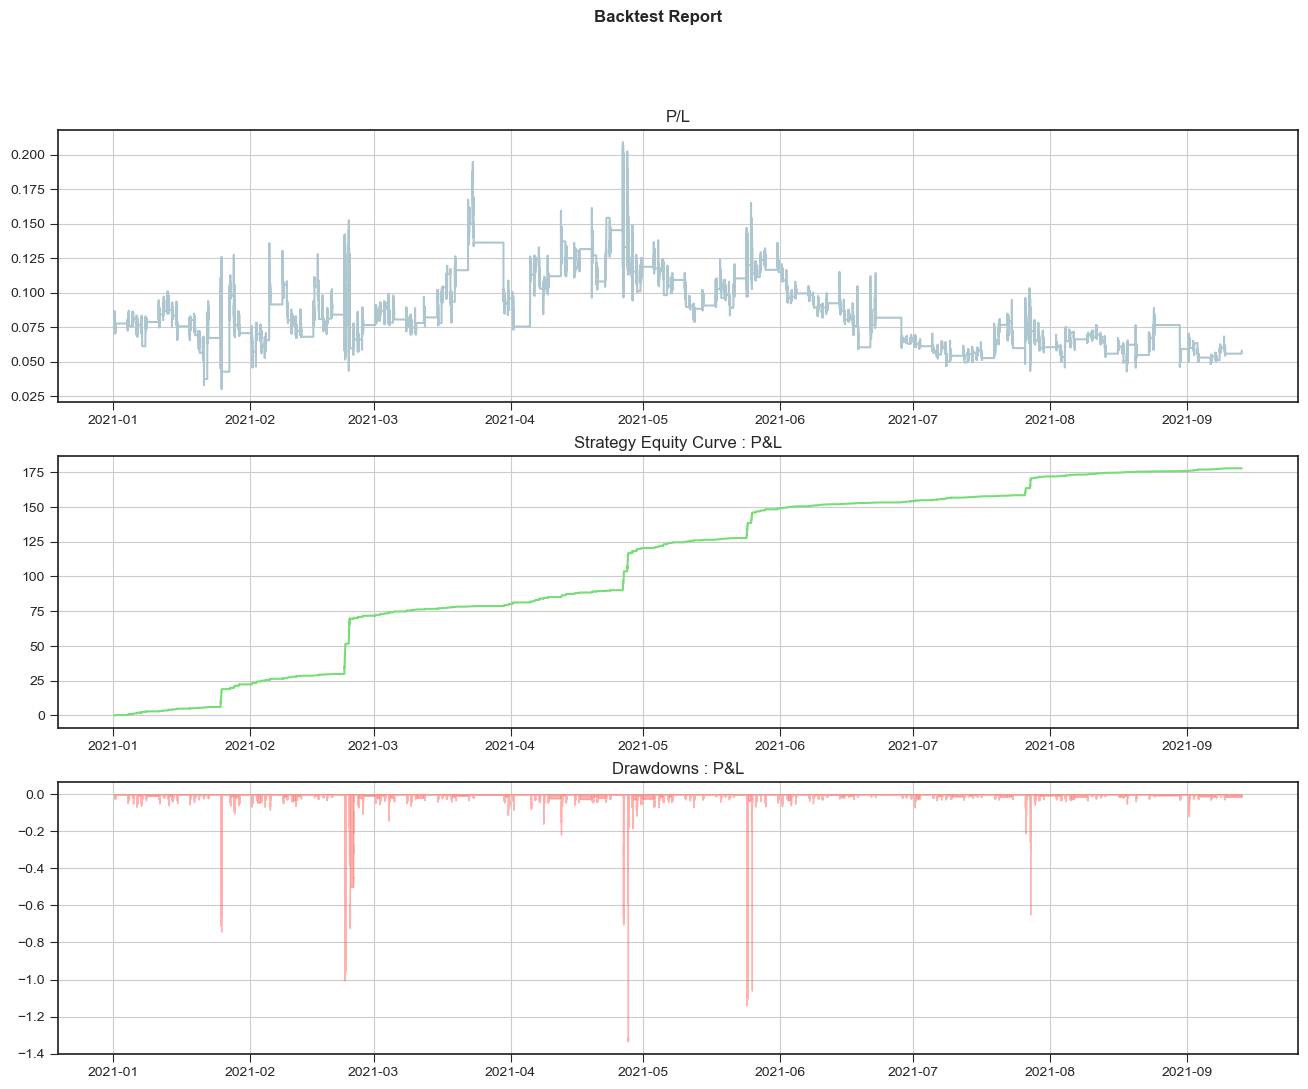

In [24]:
# initializing the strategy with 30 day lookback window 
# and 0.75 & 0.25 as the higher and lower quintile thresholds
strat = QuintileStrategy(ins, window_size=30, 
                         higher_quintile=0.75, 
                         lower_quintile=0.25)
# run the backtest
strat.run()
# get the backtest summary
strat.get_summary()

## Optimizing Quintile based Trading System

### In-sample optimization

In [25]:

opt = Optimizer(QuintileStrategy, ins)
# search paramters
params = {
    'lower_quintile': [0.01, 0.05, 0.1, 0.2, 0.25],
    'higher_quintile': [0.99, 0.95, 0.9, 0.8, 0.75]
}
# run search
opt.search(params)

  0%|          | 0/25 [00:00<?, ?it/s]

Best sharpe score achived : 7.719653999621659

Best parameters for the above score : {'lower_quintile': 0.1, 'higher_quintile': 0.99}


### Out of Sample performance

                   Results              
-------------------------------------------
     statistic                 value
-------------------------------------------
      Absolute P&L :               135.67
      Sharpe Ratio :                 8.26
  Max. Drawdown P&L:                -0.85


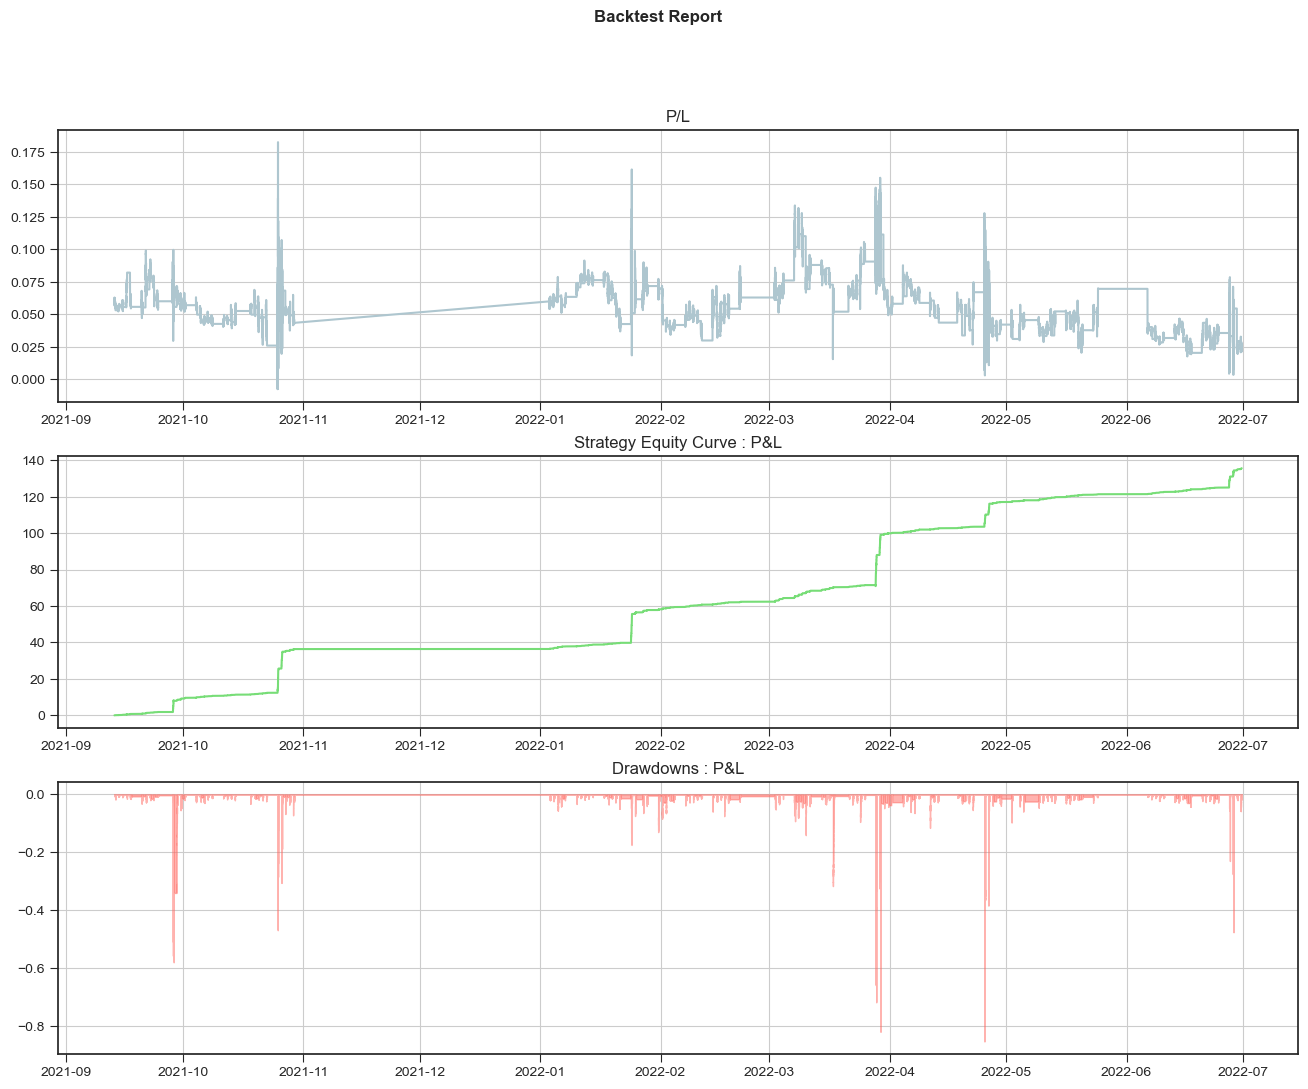

In [26]:
# initializing the strategy with 30 day lookback window 
strat = QuintileStrategy(oos, window_size=30, 
                         higher_quintile=0.99, 
                         lower_quintile=0.1)
# run the backtest
strat.run()
# get the backtest summary
strat.get_summary()

# Step 5: Results

Comparing the Quintile based trading system with our benchmark trading strategy (Z-score based)

### In-sample Performance
| Comparision Metric| Quintile Strategy | Z-Score Stategy |
| :---------------- | :------: | ----: |
| Absolute P/L      | 170.29   | 91.73|
| Sharpe Ratio       |   5.56   | 3.76 |
| Maximum Drawdown  |  -1.58   | -1.69 |

### Out-of-sample Performance

| Comparision Metric| Quintile Strategy | Z-Score Stategy |
| :---------------- | :------: | ----: |
| Absolute P/L      | 136.73   | 161.28|
| Sharpe Ratio       |   7.75   | 6.64 |
| Maximum Drawdown  |  -1.06   | -1.94 |

# Conclusion

**Absolute P&L:** The Quintile Strategy outperformed the Z-Score Strategy in both in-sample and out-of-sample periods, indicating higher profitability.

**Sharpe Ratio:** The Quintile Strategy achieved higher Sharpe ratios compared to the Z-Score Strategy in both periods, implying better risk-adjusted returns.

**Maximum Drawdown:** Both strategies experienced relatively low maximum drawdowns, with the Quintile Strategy having a slightly lower drawdown compared to the Z-Score Strategy.

From the above results we can concluded that overall the **Qunitle based trading system performed much better than the Z-Score based trading system** both in-sample and out-of-sample. Althought the absolute P&L of the Quintile based strategy was slightly lower then the Z-Score based strategy during out-of-sample test, but the risk metrics (higher Sharpe ratio and lower Maximum drawdown) for the Quintile strategy seems to better.

Overall, based on the provided performance metrics, the Quintile Strategy demonstrates superior performance compared to the Z-Score Strategy in terms of profitability, risk-adjusted returns, and drawdown management, both in the in-sample and out-of-sample periods.

# Future Prospective
- Improve the accuracy of the backtest results by implementing transaction cost, commissions and slippage.
- Use an Event Driven Backtesting methodology for emulating real market scenarios with less assumptions like immediate execution for both the assets.
- Develop a improved strategy to forecast the spread n-steps ahead and take trading decision based on it, rather than fixed threshold based system.

**---------------------------------------------------------------------------------------------Thank You------------------------------------------------------------------------------------------------------**